In [1]:
import numpy as np, pandas as pd
from glob import glob
from astropy.table import Table
from matplotlib import pyplot as plt, colors as colors, colorbar as cbar
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u

%matplotlib inline

Sample was generated using queries similar to the following, in slices in Galactic longitude. So assuming distances from Bailer-Jones, we can pick out lots of bright things!
```
SELECT gaia.source_id, wise_match.original_ext_source_id, wise_match.allwise_oid, wise.designation, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_error, gaia.a_g_val, gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, gaia_dist.r_est, gaia_dist.r_lo, gaia_dist.r_hi, gaia_dist.r_len, wise.w1mpro, wise.w1mpro_error, wise.w2mpro, wise.w2mpro_error, wise.w3mpro, wise.w3mpro_error, wise.w4mpro, wise.w4mpro_error
FROM gaiadr2.gaia_source as gaia 
INNER JOIN external.gaiadr2_geometric_distance as gaia_dist ON gaia.source_id = gaia_dist.source_id
INNER JOIN gaiadr2.allwise_best_neighbour as wise_match ON gaia.source_id = wise_match.source_id
INNER JOIN gaiadr1.allwise_original_valid as wise ON wise_match.allwise_oid=wise.allwise_oid
WHERE gaia.phot_g_mean_mag - 5 * log10(gaia_dist.r_est) + 5 <= -1.5
AND gaia.l >= 180
AND gaia.l < 240
AND wise.w1mpro < 14
AND gaia_dist.result_flag > 0 
```

In [2]:
tables = glob('bright_*-*-result.csv')
tables

['bright_0-15-result.csv',
 'bright_120-180-result.csv',
 'bright_15-30-result.csv',
 'bright_180-240-result.csv',
 'bright_240-270-result.csv',
 'bright_270-285-result.csv',
 'bright_285-300-result.csv',
 'bright_30-45-result.csv',
 'bright_300-315-result.csv',
 'bright_315-330-result.csv',
 'bright_330-345-result.csv',
 'bright_345-360-result.csv',
 'bright_45-60-result.csv',
 'bright_60-75-result.csv',
 'bright_75-90-result.csv',
 'bright_90-120-result.csv']

We also uploaded the sample from Helmi et al. (2018, 2018A&A...616A..12G) who filtered for stars in the Magellanic Clouds, then ran 

```
SELECT gaia.source_id, wise_match.original_ext_source_id, wise_match.allwise_oid, wise.designation, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_error, gaia.a_g_val, gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, wise.w1mpro, wise.w1mpro_error, wise.w2mpro, wise.w2mpro_error, wise.w3mpro, wise.w3mpro_error, wise.w4mpro, wise.w4mpro_error
FROM gaiadr2.gaia_source as gaia 
INNER JOIN user_tdornwal.gaia_lmc as gaia_lmc ON gaia.source_id = gaia_lmc.col2
INNER JOIN gaiadr2.allwise_best_neighbour as wise_match ON gaia.source_id = wise_match.source_id
INNER JOIN gaiadr1.allwise_original_valid as wise ON wise_match.allwise_oid=wise.allwise_oid
WHERE gaia.phot_g_mean_mag - 18.52 <= -1.5
AND wise.w1mpro < 14
```

Where 18.52 is the distance modulus for the LMC (Kovacs 2000), and a similar query for the SMC.

In [3]:
mc_tables = glob('bright*mc*')
mc_tables

['bright_lmc-result.csv', 'bright_smc-result.csv']

In [4]:
#Put together the individual results, adding in colors, and absolute mags.
#We'll correct for extinction if we have A_G values

#Coefficients from Malhan, Ibata & Martin (2018a), ratio of A_X/A_V
ag_av = 0.85926
ab_av = 1.06794
ar_av = 0.65199

dfs = []
for t in tables:
    temp = pd.read_csv(t)
    temp.fillna(value={'a_g_val':0},inplace=True)
    ebprp = (temp['a_g_val']/ag_av)*(ab_av-ar_av)
    temp['BP-RP'] = temp['phot_bp_mean_mag'] - temp['phot_rp_mean_mag'] - ebprp
    temp['W1-W2'] = temp['w1mpro']-temp['w2mpro']
    temp['W2-W3'] = temp['w2mpro']-temp['w3mpro']
    temp['W3-W4'] = temp['w3mpro']-temp['w4mpro']
    temp['M_W1'] = temp['w1mpro'] - 5 * np.log10(temp['r_est']) + 5 - temp['a_g_val']
    temp['M_G'] = temp['phot_g_mean_mag'] - 5 * np.log10(temp['r_est']) + 5 - temp['a_g_val']
    temp['Galaxy'] = ['Milky Way' for i in range(len(temp))]
    dfs.append(temp)
    
result = pd.concat(dfs)

len(result)

211730

In [5]:
#Same for LMC/SMC, using average R_V (Gordon et al. 2003) and E(B-V) (Massey et al. 2007)
#for stars with no a_g estimate
dfs = []
for t,distance_modulus,galaxy,rv,ebv in zip(mc_tables,[18.52,19.05],['LMC','SMC'],[3.41,2.75],[0.13,0.09]):
    temp = pd.read_csv(t)
    #convert to an A_V, then A_G to fill
    ag = rv*ebv*ag_av
    temp.fillna(value={'a_g_val':ag},inplace=True)
    ebprp = (temp['a_g_val']/ag_av)*(ab_av-ar_av)
    temp['BP-RP'] = temp['phot_bp_mean_mag'] - temp['phot_rp_mean_mag'] - ebprp
    temp['W1-W2'] = temp['w1mpro']-temp['w2mpro']
    temp['W2-W3'] = temp['w2mpro']-temp['w3mpro']
    temp['W3-W4'] = temp['w3mpro']-temp['w4mpro']
    temp['M_W1'] = temp['w1mpro'] - distance_modulus
    temp['M_G'] = temp['phot_g_mean_mag'] - distance_modulus - temp['a_g_val']
    temp['Galaxy'] = [galaxy for i in range(len(temp))]
    dfs.append(temp)
    
mc_result = pd.concat(dfs)

len(mc_result)

244525

In [6]:
#All told, this many stars. But some are duplicates!
len(result) + len(mc_result)

456255

In [7]:
#Separate out MC stars from Galactic stars
galactic_result = result[~result['source_id'].isin(mc_result['source_id'])]
#Add MC stars back in
all_stars = pd.concat([galactic_result,mc_result])
len(all_stars)

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



452283

In [8]:
#Now let's try to isolate massive stars using MIST. Take all isochrones with initial mass > 8
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

MWnames = ('EEP','log10_isochrone_age_yr','initial_mass','star_mass','log_Teff',
           'log_g','log_L','[Fe/H]_init','[Fe/H]','WISE_W1','WISE_W2','WISE_W3',
           'WISE_W4','phase')

#Adopting [Fe/H] = 0,-0.5,-1 for galactic massive stars, the LMC, and the SMC respectively...
Galfile = '../MIST/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
LMCfile = '../MIST/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_m0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
SMCfile = '../MIST/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_m1.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'

Gmist = pd.read_table(Galfile, delim_whitespace=True, comment='#', names=Mnames)
Lmist = pd.read_table(LMCfile, delim_whitespace=True, comment='#', names=Mnames)
Smist = pd.read_table(SMCfile, delim_whitespace=True, comment='#', names=Mnames)

min_col_arrs = ()
min_mag_arrs = ()

for mist in [Gmist,Lmist,Smist]:
    
    mist_massive = mist[(mist['initial_mass'] >= 8)]

    #Now, in each color bin, give me the color and magnitude of the faintest star.
    col_bins = np.linspace(-0.25,3,100)
    min_cols = []
    min_mags = []

    for i,left in enumerate(col_bins[:-1]):
        mist_subset = mist_massive[(mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']>left)&
                                   (mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']<=col_bins[i+1])]
        min_point = mist_subset[mist_subset['Gaia_G_DR2Rev']==np.max(mist_subset['Gaia_G_DR2Rev'])]
        if len(min_point) != 0:
            min_cols.append((min_point['Gaia_BP_DR2Rev'].values-min_point['Gaia_RP_DR2Rev'].values)[0])
            min_mags.append((min_point['Gaia_G_DR2Rev'].values)[0])
    min_col_arrs += (min_cols, )
    min_mag_arrs += (min_mags, )
    
Gmin_cols, Lmin_cols, Smin_cols = min_col_arrs
Gmin_mags, Lmin_mags, Smin_mags = min_mag_arrs

/Users/carina/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #For each star's precise color, interpolate to the magnitude threshold 
    #This threshold depends on what galaxy its in
    minmag_G = np.interp(all_stars['BP-RP'], Gmin_cols, Gmin_mags)
    minmag_L = np.interp(all_stars['BP-RP'], Lmin_cols, Lmin_mags)
    minmag_S = np.interp(all_stars['BP-RP'], Smin_cols, Smin_mags)

    massive_G = all_stars[(all_stars['Galaxy'] == 'Milky Way')&(all_stars['M_G'] <= minmag_G)]
    massive_L = all_stars[(all_stars['Galaxy'] == 'LMC')&(all_stars['M_G'] <= minmag_L)]
    massive_S = all_stars[(all_stars['Galaxy'] == 'SMC')&(all_stars['M_G'] <= minmag_S)]

    massive = pd.concat([massive_G,massive_L,massive_S])
    massive.sort_values('phot_g_mean_mag',inplace=True)
len(massive)

9784

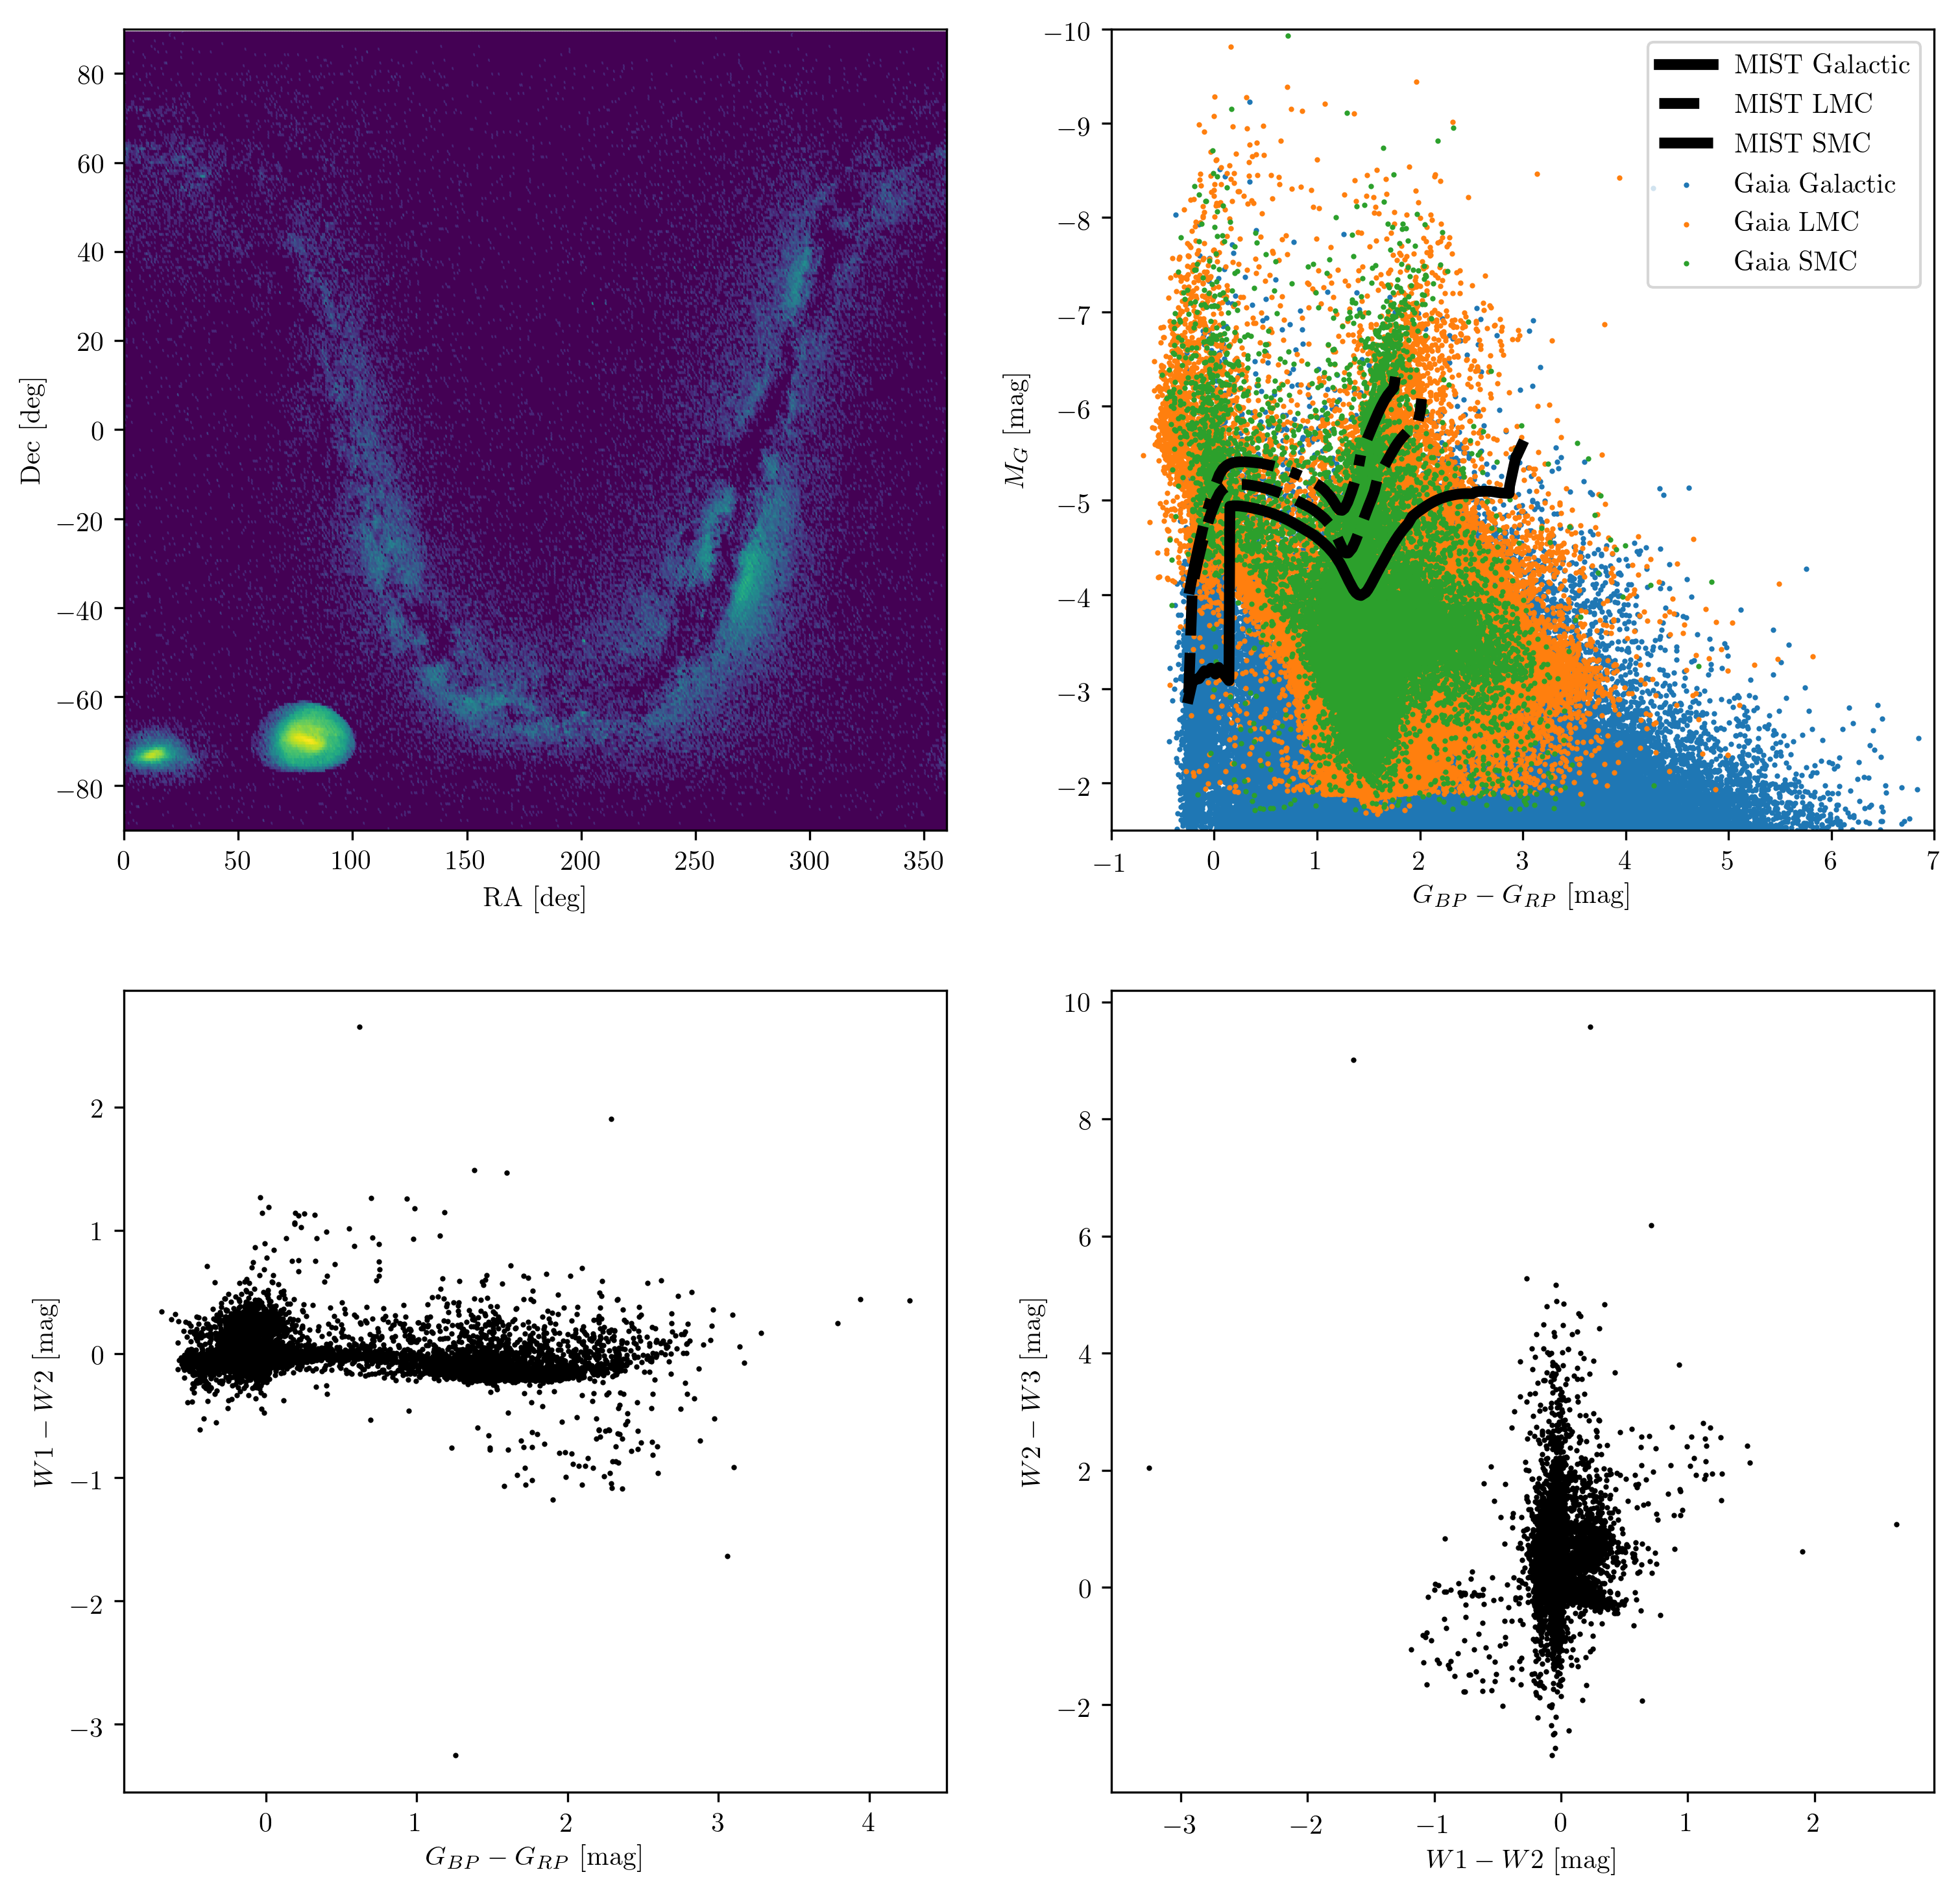

In [10]:
#Summary figure
fig, axes = plt.subplots(2,2,figsize=(12,12),dpi=300)

axes[0,0].hexbin(all_stars['ra'],all_stars['dec'],bins='log',gridsize=500)
axes[0,0].set(xlim=(0,360),ylim=(-90,90),xlabel='RA [deg]',ylabel='Dec [deg]')

axes[0,1].plot(Gmin_cols,Gmin_mags,'-k',lw=4,label='MIST Galactic')
axes[0,1].plot(Lmin_cols,Lmin_mags,'--k',lw=4,label='MIST LMC')
axes[0,1].plot(Smin_cols,Smin_mags,'-.k',lw=4,label='MIST SMC')
axes[0,1].scatter(all_stars[all_stars['Galaxy']=='Milky Way']['BP-RP'],all_stars[all_stars['Galaxy']=='Milky Way']['M_G'],s=1,label='Gaia Galactic')
axes[0,1].scatter(all_stars[all_stars['Galaxy']=='LMC']['BP-RP'],all_stars[all_stars['Galaxy']=='LMC']['M_G'],s=1,label='Gaia LMC')
axes[0,1].scatter(all_stars[all_stars['Galaxy']=='SMC']['BP-RP'],all_stars[all_stars['Galaxy']=='SMC']['M_G'],s=1,label='Gaia SMC')
axes[0,1].legend()
axes[0,1].set(xlim=(-1,7), ylim=(-1.5,-10), xlabel=(r'$G_{BP}-G_{RP}$ [mag]'), ylabel=('$M_G$ [mag]'))

axes[1,0].scatter(massive['BP-RP'],massive['W1-W2'],s=1,c='k')
axes[1,0].set(xlabel=r'$G_{BP}-G_{RP}$ [mag]',ylabel=r'$W1-W2$ [mag]');

axes[1,1].scatter(massive['W1-W2'],massive['W2-W3'],s=1,c='k')
axes[1,1].set(xlabel=r'$W1-W2$ [mag]',ylabel='$W2-W3$ [mag]');

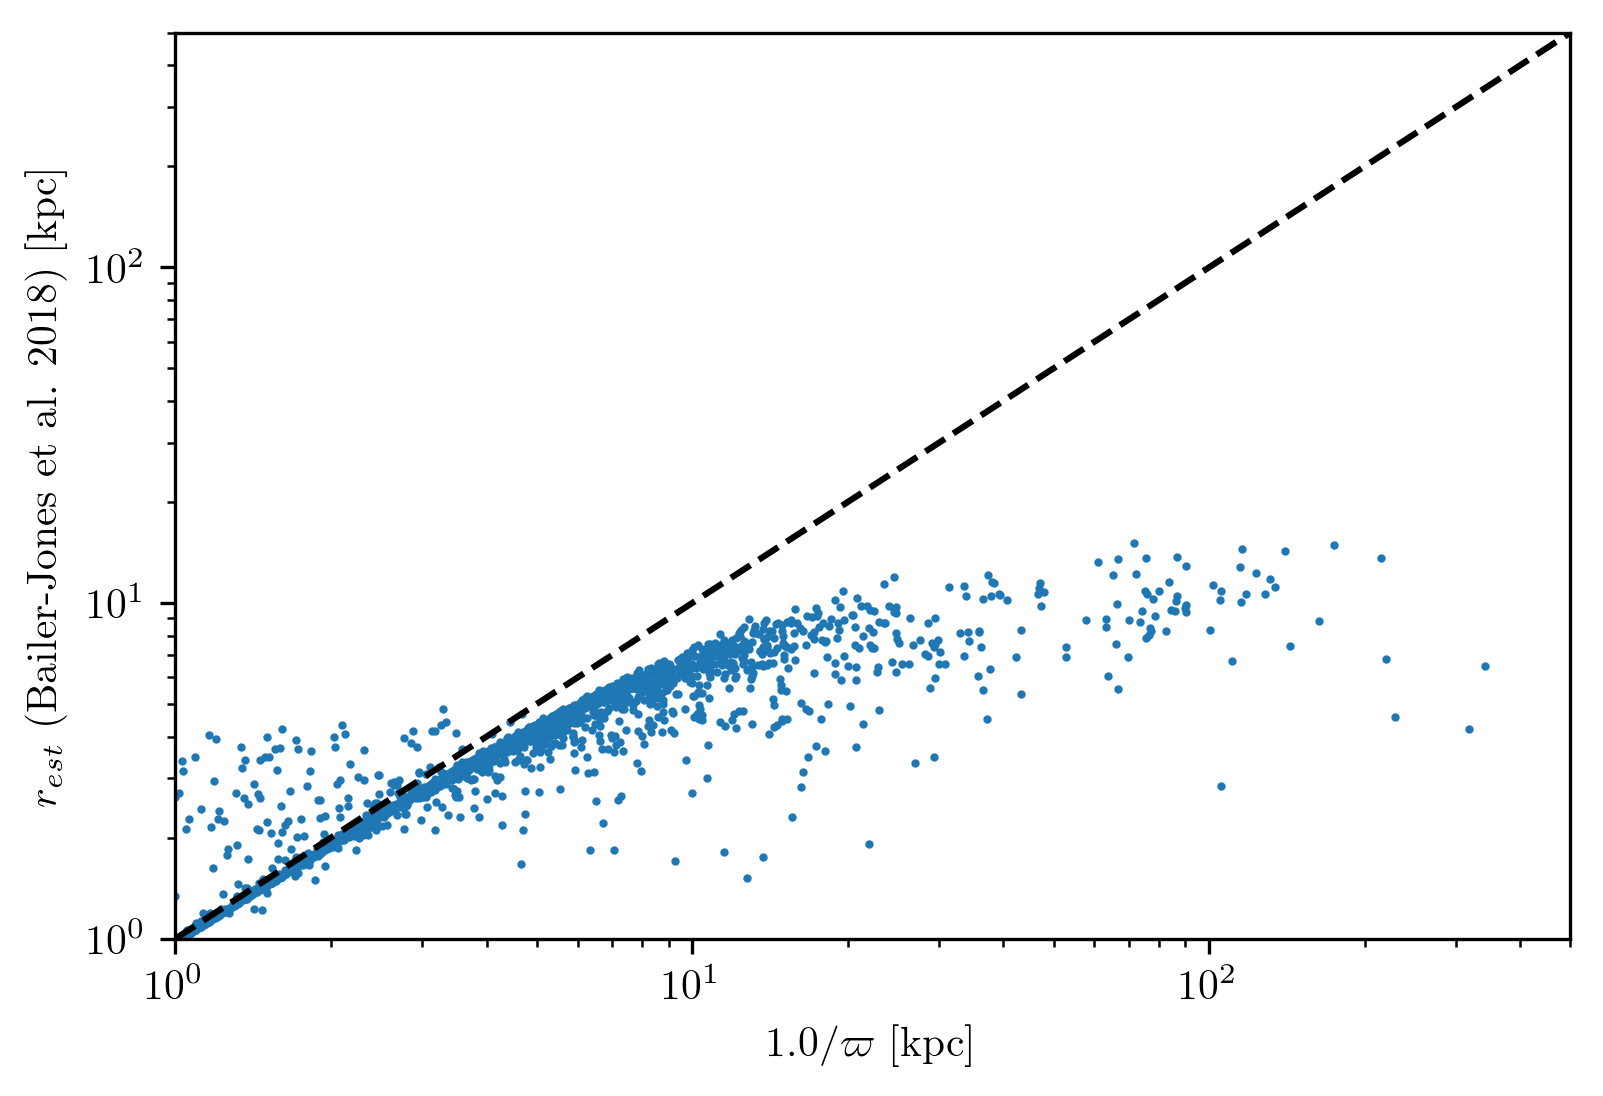

In [11]:
plt.figure(dpi=300)
plt.scatter(1.0/massive['parallax'],1.0e-3*massive['r_est'],s=1)
plt.gca().set(xscale='log',yscale='log',xlim=(1,5e2),ylim=(1,5e2))
plt.plot([1,5e2],[1,5e2],'--k',label='1 to 1')
plt.xlabel(r'$1.0/\varpi$ [kpc]')
plt.ylabel(r'$r_{est}$ (Bailer-Jones et al. 2018) [kpc]')
plt.savefig('dist_invparallax.eps')

In [12]:
#We can also do some cuts using WISE data
#We'll select for SNR in flux densities instead of magnitudes...
w1_zp = 20.5
w2_zp = 19.5
w3_zp = 18.0
w4_zp = 13.0

w1_flux = np.power(10.0,(w1_zp - massive['w1mpro'])/2.5)
w1_flux_err = w1_flux * (np.log(10.0)/2.5)*massive['w1mpro_error']

w2_flux = np.power(10.0,(w2_zp - massive['w2mpro'])/2.5)
w2_flux_err = w2_flux * (np.log(10.0)/2.5)*massive['w2mpro_error']

w3_flux = np.power(10.0,(w3_zp - massive['w3mpro'])/2.5)
w3_flux_err = w3_flux * (np.log(10.0)/2.5)*massive['w3mpro_error']

w4_flux = np.power(10.0,(w4_zp - massive['w4mpro'])/2.5)
w4_flux_err = w4_flux * (np.log(10.0)/2.5)*massive['w4mpro_error']

w1_flux_snr = w1_flux/w1_flux_err
w2_flux_snr = w2_flux/w2_flux_err
w3_flux_snr = w3_flux/w3_flux_err
w4_flux_snr = w4_flux/w4_flux_err

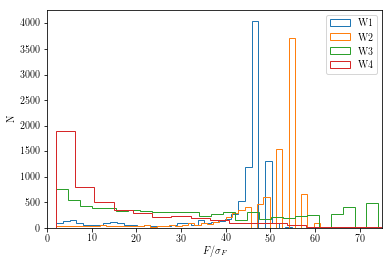

In [13]:
plt.hist(w1_flux_snr[~np.isnan(w1_flux_snr)],histtype='step',bins=50,label='W1')
plt.hist(w2_flux_snr[~np.isnan(w2_flux_snr)],histtype='step',bins=50,label='W2')
plt.hist(w3_flux_snr[~np.isnan(w3_flux_snr)],histtype='step',bins=50,label='W3')
plt.hist(w4_flux_snr[~np.isnan(w4_flux_snr)],histtype='step',bins=50,label='W4')
plt.xlabel('$F/\sigma_{F}$')
plt.ylabel('N')
plt.xlim(0,75)
plt.legend()

In [14]:
#Which columns have NaNs in them?
for col,dt in zip(massive.columns,massive.dtypes):
    if (dt != object):
        if np.any(np.isnan(massive[col])):
            print(col)

W1-W2
W2-W3
W3-W4
r_est
r_hi
r_len
r_lo
w1mpro_error
w2mpro
w2mpro_error
w3mpro
w3mpro_error
w4mpro
w4mpro_error


In [15]:
#Take only rows without WISE NaNs, with SNR in W1 and W2 flux > 3, but fainter than the saturation limit
#From http://wise2.ipac.caltech.edu/docs/release/neowise/expsup/sec2_1c.html
good_cond = (
    (~np.isnan(massive['w1mpro_error'])) & 
    (~np.isnan(massive['w2mpro_error'])) & 
    (~np.isnan(massive['w2mpro'])) &
    (~np.isnan(massive['w3mpro_error'])) & 
    (~np.isnan(massive['w3mpro'])) &
    (w1_flux_snr >= 3) &
    (w2_flux_snr >= 3) &
    (massive['w1mpro'] >= 8.0) &
    (massive['w2mpro'] >= 7.0) 
)
             
good = massive[good_cond]
print(len(good))

6484


```python
#Append Object Name, SpT, etc.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    customSimbad = Simbad()
    customSimbad.add_votable_fields('mk', 'otype', 'sptype')
    common_names = []
    mks = []
    otypes = []
    sptypes = []
    for i,row in good.iterrows():
        coords = coord.SkyCoord(row['ra'],row['dec'],frame='icrs',unit=u.deg)
        try:
            result_table = customSimbad.query_region(coords, radius=2*u.arcsec)
        except:
            try:
                result_table = customSimbad.query_object('Gaia '+row['source_id'])
            except:
                print('broke on WISE',row['designation'])
                common_names.append('WISE'+row['designation'])
                mks.append(np.nan)
                otypes.append(np.nan)
                sptypes.append(np.nan)
                continue
        try:
            common_name = result_table['MAIN_ID'][0].decode('utf8')
            mk = result_table['MK_Spectral_type'][0].decode('utf8')
            otype = result_table['OTYPE'][0].decode('utf8')
            sptype = result_table['SP_TYPE'][0].decode('utf8')
            common_names.append(common_name)
            mks.append(mk)
            otypes.append(otype)
            sptypes.append(sptype)
        except TypeError:
            common_names.append('WISE'+row['designation'])
            mks.append(np.nan)
            otypes.append(np.nan)
            sptypes.append(np.nan)
    good['CommonName'] = common_names
    good['MKType'] = mks
    good['SimbadOType'] = otypes
    good['SpT'] = sptypes
 ```

In [43]:
#That block added in Simbad info to good. Let's load it in now.
good = pd.read_csv('massive.csv.gz')
good

,BP-RP,Galaxy,M_G,M_W1,W1-W2,W2-W3,W3-W4,a_g_val,allwise_oid,dec,...,w2mpro,w2mpro_error,w3mpro,w3mpro_error,w4mpro,w4mpro_error,CommonName,MKType,SimbadOType,SpT
0,-0.329016,Milky Way,-4.781864,-4.040434,-0.057,-0.048,-0.387,0.0000,616462540,41.479893,...,8.205,0.020,8.253,0.022,8.640,0.430,HD 14633,O8.5V,SB*,ON8.5V
1,-0.274395,Milky Way,-3.658367,-3.054401,-0.059,-0.040,-0.143,0.0190,654202252,49.611386,...,8.118,0.020,8.158,0.024,8.301,0.236,HD 77770,B2IV,Star,B2IV
2,-0.243995,Milky Way,-3.042140,-2.646325,-0.039,-0.105,-0.043,0.1480,115637938,-46.600496,...,8.051,0.018,8.156,0.022,8.199,0.328,HD 158906,B2/3II,Star,B2/3II
3,-0.309054,Milky Way,-2.952449,-2.267720,-0.093,-0.007,0.212,0.0000,326629530,-9.761426,...,8.413,0.020,8.420,0.024,8.208,0.287,HD 220172,B3II,Star,B3II
4,-0.201491,Milky Way,-3.355478,-2.879618,-0.059,-0.037,0.002,0.0545,71520251,-56.293117,...,8.188,0.020,8.225,0.019,8.223,0.140,HD 104200,OB,Star,B0.5/1III
5,-0.230171,Milky Way,-3.149928,-2.669357,-0.051,-0.006,0.765,0.0200,213394124,-28.689332,...,8.190,0.019,8.196,0.020,7.431,0.138,HD 71928,B2II/III,Star,B2II/III
6,-0.231501,Milky Way,-4.224189,-3.841554,-0.054,-0.014,-0.059,0.2340,612300492,40.626816,...,8.137,0.020,8.151,0.021,8.210,0.182,HD 185780,B0III,EB*,B0III
7,-0.295175,Milky Way,-3.316496,-2.711689,-0.053,-0.051,0.277,0.0830,241432255,-23.934246,...,8.359,0.020,8.410,0.023,8.133,0.228,HD 60344,OB-,Star,B2III
8,-0.289132,Milky Way,-4.358767,-3.662722,-0.052,-0.013,0.178,0.0000,643618617,47.244700,...,8.463,0.018,8.476,0.020,8.298,0.187,HD 186618,B0III,Star,B0V
9,-0.271684,Milky Way,-3.263516,-2.710353,-0.048,0.088,1.905,0.0595,524596070,24.008020,...,8.320,0.021,8.232,0.025,6.327,0.066,HD 50767,B2V,Star,B2V


for i,row in good.iloc[:200].iterrows():
    print(row['CommonName'],row['SpT'],row['SimbadOType'])

Text(0, 0.5, 'N')

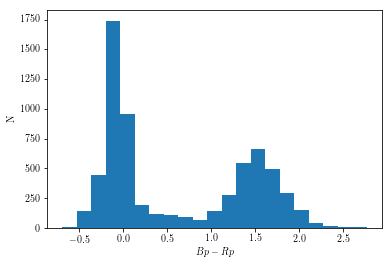

In [19]:
#Distribution of Bp - Rp
plt.hist(good['BP-RP'],bins='auto')
plt.xlabel(r'$Bp-Rp$')
plt.ylabel('N')

Text(0, 0.5, 'N')

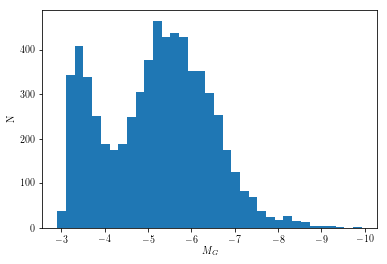

In [20]:
#Distribution of Absolute G mag
plt.hist(good['M_G'],bins='auto');
plt.gca().invert_xaxis()
plt.xlabel(r'$M_G$')
plt.ylabel('N')

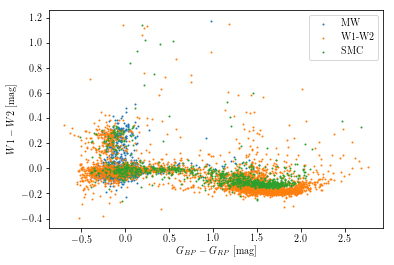

In [21]:
plt.scatter(good['BP-RP'][good['Galaxy'] == 'Milky Way'],good['W1-W2'][good['Galaxy'] == 'Milky Way'],s=1,label='MW')
plt.scatter(good['BP-RP'][good['Galaxy'] == 'LMC'],good['W1-W2'][good['Galaxy'] == 'LMC'],s=1)
plt.scatter(good['BP-RP'][good['Galaxy'] == 'SMC'],good['W1-W2'][good['Galaxy'] == 'SMC'],s=1,label='SMC')
plt.gca().set(xlabel=r'$G_{BP}-G_{RP}$ [mag]',ylabel=r'$W1-W2$ [mag]')
plt.legend()

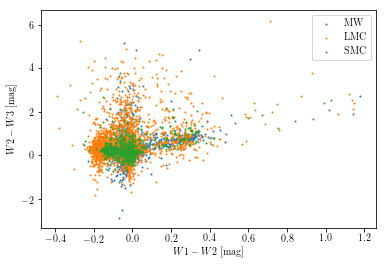

In [22]:
plt.scatter(good['W1-W2'][good['Galaxy'] == 'Milky Way'],good['W2-W3'][good['Galaxy'] == 'Milky Way'],s=1,label='MW')
plt.scatter(good['W1-W2'][good['Galaxy'] == 'LMC'],good['W2-W3'][good['Galaxy'] == 'LMC'],s=1,label='LMC')
plt.scatter(good['W1-W2'][good['Galaxy'] == 'SMC'],good['W2-W3'][good['Galaxy'] == 'SMC'],s=1,label='SMC')
plt.gca().set(ylabel=r'$W2-W3$ [mag]',xlabel=r'$W1-W2$ [mag]')
plt.legend()

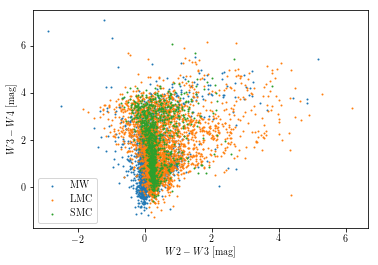

In [23]:
plt.scatter(good['W2-W3'][good['Galaxy'] == 'Milky Way'],good['W3-W4'][good['Galaxy'] == 'Milky Way'],s=1,label='MW')
plt.scatter(good['W2-W3'][good['Galaxy'] == 'LMC'],good['W3-W4'][good['Galaxy'] == 'LMC'],s=1,label='LMC')
plt.scatter(good['W2-W3'][good['Galaxy'] == 'SMC'],good['W3-W4'][good['Galaxy'] == 'SMC'],s=1,label='SMC')
plt.gca().set(xlabel=r'$W2-W3$ [mag]',ylabel=r'$W3-W4$ [mag]')
plt.legend()

# Now let's play with the sample a bit, make some plots

In [24]:
MainSequence = good[(good['BP-RP'] < 0.5)&good['W1-W2']<=0.075]
PostMainSequence = good[good['BP-RP'] >= 0.5]
DustyMS = good[(good['BP-RP'] < 0.5)&(good['W1-W2'] > 0.075)]

[Text(0, 0.5, '$W2-W3$ [mag]'), Text(0.5, 0, '$W1-W2$ [mag]')]

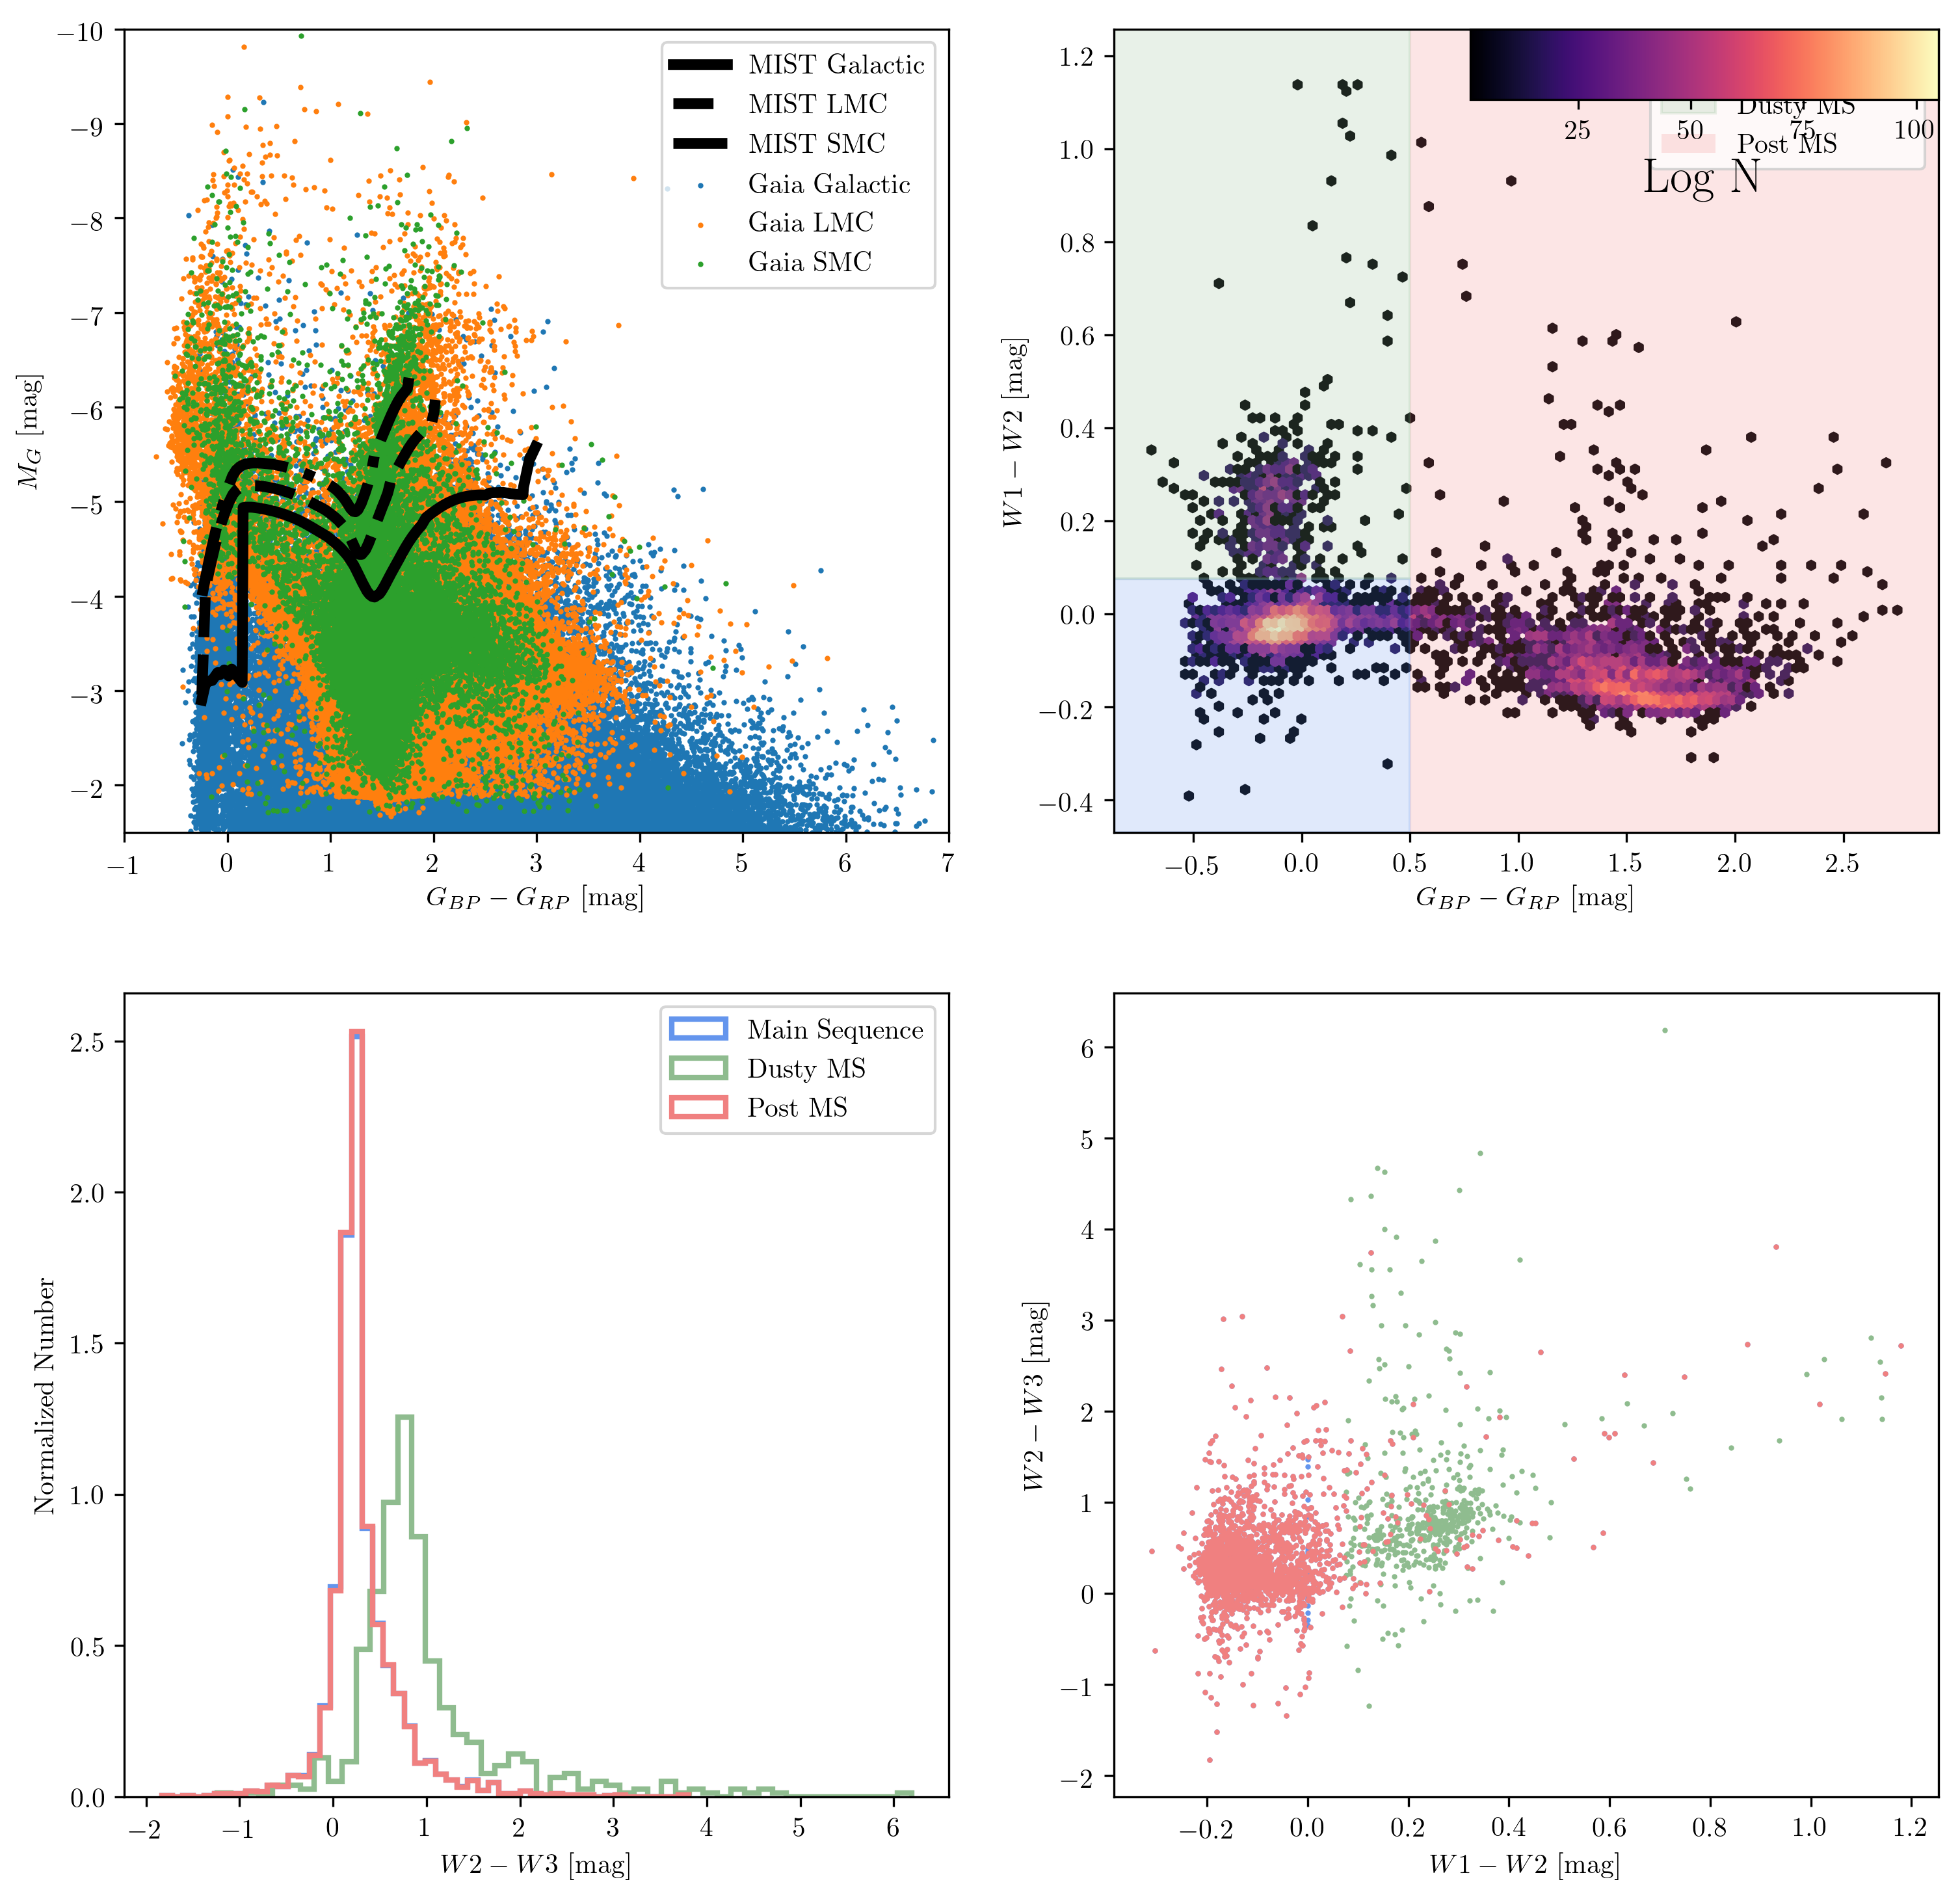

In [25]:
fig, axes = plt.subplots(2,2,figsize=(12,12),dpi=300)

axes[0,0].plot(Gmin_cols,Gmin_mags,'-k',lw=4,label='MIST Galactic')
axes[0,0].plot(Lmin_cols,Lmin_mags,'--k',lw=4,label='MIST LMC')
axes[0,0].plot(Smin_cols,Smin_mags,'-.k',lw=4,label='MIST SMC')
axes[0,0].scatter(all_stars[all_stars['Galaxy']=='Milky Way']['BP-RP'],all_stars[all_stars['Galaxy']=='Milky Way']['M_G'],s=1,label='Gaia Galactic')
axes[0,0].scatter(all_stars[all_stars['Galaxy']=='LMC']['BP-RP'],all_stars[all_stars['Galaxy']=='LMC']['M_G'],s=1,label='Gaia LMC')
axes[0,0].scatter(all_stars[all_stars['Galaxy']=='SMC']['BP-RP'],all_stars[all_stars['Galaxy']=='SMC']['M_G'],s=1,label='Gaia SMC')
axes[0,0].legend()
axes[0,0].set(xlim=(-1,7), ylim=(-1.5,-10), xlabel=(r'$G_{BP}-G_{RP}$ [mag]'), ylabel=('$M_G$ [mag]'))


opt_color = good['BP-RP']
ir_color = good['W1-W2']
hexb = axes[0,1].hexbin(opt_color,ir_color,mincnt=1, bins='log', cmap='magma')
colax_xlim = axes[0,1].get_xlim()
colax_ylim = axes[0,1].get_ylim()
axes[0,1].fill([colax_xlim[0],0.5,0.5,colax_xlim[0]],[colax_ylim[0],colax_ylim[0],0.075,0.075],
           alpha=0.2,c='cornflowerblue',label='Main Sequence')
axes[0,1].fill([colax_xlim[0],0.5,0.5,colax_xlim[0]],[0.075,0.075,colax_ylim[1],colax_ylim[1]],
           alpha=0.2,c='darkseagreen',label='Dusty MS')
axes[0,1].axvspan(xmin=0.5,xmax=colax_xlim[1],facecolor='lightcoral',
              alpha=0.2,label='Post MS')
axes[0,1].set(xlim=colax_xlim,ylim=colax_ylim,xlabel=r'$G_{BP}-G_{RP}$ [mag]',ylabel=r'$W1-W2$ [mag]')
h,l = axes[0,1].get_legend_handles_labels()
axes[0,1].legend(h[:3], l[:3])
hexclim = hexb.get_clim()
cbax = fig.add_subplot(121)
bounds = axes[0,1].get_position()
cbax.set_position([bounds.x0+bounds.width-0.2,bounds.y0+bounds.height-0.03, 0.2, 0.03])
norm = colors.Normalize(vmin=hexclim[0], vmax=hexclim[1])
cb1 = cbar.ColorbarBase(cbax, cmap='magma',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Log N',fontsize=18)

dfs = [MainSequence,DustyMS,PostMainSequence]
cs = ['cornflowerblue','darkseagreen','lightcoral']
labels = ['Main Sequence','Dusty MS','Post MS']
for df,c,l in zip(dfs,cs,labels):
    axes[1,0].hist(df['W2-W3'],color=c,label=l,histtype='step',density=True,bins=50,lw=2)
axes[1,0].legend()
axes[1,0].set(xlabel='$W2-W3$ [mag]',ylabel='Normalized Number')

axes[1,1].scatter(MainSequence['W1-W2'],MainSequence['W2-W3'],s=1,c='cornflowerblue')
axes[1,1].scatter(DustyMS['W1-W2'],DustyMS['W2-W3'],s=1,c='darkseagreen')
axes[1,1].scatter(PostMainSequence['W1-W2'],PostMainSequence['W2-W3'],s=1,c='lightcoral')
axes[1,1].set(ylabel=r'$W2-W3$ [mag]',xlabel=r'$W1-W2$ [mag]')

#plt.savefig('sample_plots.pdf')

In [26]:
#Let's write out to CSV
good.to_csv('massive.csv.gz',index=False,compression='gzip')

In [27]:
len(PostMainSequence)+len(DustyMS)

3390